In [41]:
import os
import nmrglue as ng
import matplotlib.pyplot as plt
import numpy as np
import struct
from scipy.integrate import simps
from scipy.spatial import ConvexHull
import datetime
import pandas as pd

In [30]:
parent_dir="testfolder"

MIN_PEAK_HEIGHT=0.05 #5% of max as 
MAX_HEIGHT_PEAK_SEP=0.1 #if prominence between two signals larger than this, treat as one (large overapp)
PEAK_INTEGRATION_HEIGHT=0.02# relative height of peak which is the leftand right integration border
MIN_PEAK_DIST=0.2 # minimum peak distance to be evaluated as sep peaks

NORM_PEAK_PPM=1.5 # approx. ppm of the reference peak, peak closest to this value will be used as ref.
NORM_PEAK_A=2 # the target are of the reference peak

PEAK_GROUP_DELTA=0.2 #delta for grouping signals for time dependent change 

In [31]:
def read_magritek(path):
    dic,raw_data  = ng.jcampdx.read(os.path.join(path,"nmr_fid.dx"))
    udic = ng.jcampdx.guess_udic(dic,raw_data)
    npoints = int(udic[0]['size'])
    data = np.empty((npoints, ), dtype='complex128')
    data.real = raw_data[0][:]
    data.imag = raw_data[1][:]
    
    
    udic["acqu"]={}
    with open(path + '/acqu.par') as f:
        for line in f:
            eq_index = line.find('=')
            var_name = line[:eq_index].strip()
            number = (line[eq_index + 1:].strip())
            if (number.startswith('"') or number.startswith('"')) and (number.endswith('"') or number.endswith('"')):
                number=number[1:-1]
            elif "." in number:
                try:
                    number=float(number)
                except:
                    pass
            else:
                try:
                    number=int(number)
                except:
                    pass
                    
            udic["acqu"][var_name] = number
    
    udic[0]['sw'] = int(udic["acqu"]["bandwidth"])
    
    # sometimes in Hz somtimes in kHz...
    if udic[0]['sw'] < 1000:
        udic[0]['sw'] *=1000 
        
    udic[0]['car'] = float(udic["acqu"]["lowestFrequency"]) + udic[0]['sw']/ 2
    return udic,data

In [32]:

def rubberband_corection(x,y):
    v = ConvexHull(np.array(list(zip(x,y)))).vertices
    v = np.roll(v, -v.argmax())
    v = v[:v.argmin()]
    return np.interp(x, x[v], y[v])

In [33]:
import scipy.signal as signal 

def find_raw_peaks(ppm_scale,corr_data):
    points_per_ppm=len(ppm_scale)/(ppm_scale.max()-ppm_scale.min())
    peaks,peak_data = signal.find_peaks(corr_data, height=MIN_PEAK_HEIGHT, 
                                              prominence=MIN_PEAK_HEIGHT,
                                             width=points_per_ppm*MIN_PEAK_DIST*0.001,
                                              rel_height=1-PEAK_INTEGRATION_HEIGHT,
                                             )


    min_border_index=np.zeros_like(peaks)
    for i in range(1,len(peaks)):
        min_border_index[i]=corr_data[peaks[i-1]:peaks[i]].argmin()+peaks[i-1]

    max_border_index=np.zeros_like(peaks)
    for i in range(len(peaks)-1):
        max_border_index[i]=corr_data[peaks[i]:peaks[i+1]].argmin()+peaks[i]
    max_border_index[-1]=len(corr_data)-1


    data_indices=np.arange(len(corr_data))

    calc_int_bord_left=np.zeros_like(peaks)
    for i,p in enumerate(peaks):
        a = (corr_data[:p]<=peak_data['peak_heights'][i]*PEAK_INTEGRATION_HEIGHT)
        calc_int_bord_left[i]=data_indices[:p][a].max()

    calc_int_bord_right=np.zeros_like(peaks)
    for i,p in enumerate(peaks):
        a = (corr_data[p:]<=peak_data['peak_heights'][i]*PEAK_INTEGRATION_HEIGHT)
        calc_int_bord_right[i]=data_indices[p:][a].min()


    peak_left_int_bord=np.maximum(
        #np.floor(peak_data['left_ips']).astype(int),
        calc_int_bord_left,
        min_border_index,
    )
    peak_right_int_bord=np.minimum(
    #    np.ceil(peak_data['right_ips']).astype(int),
        calc_int_bord_right,
        max_border_index,
    )

    #plt.plot(ppm_scale[point_plot_min:point_plot_max],corr_data[point_plot_min:point_plot_max],)
    #plt.plot(ppm_scale[peaks],corr_data[peaks],"o")

    #plt.plot(ppm_scale[peak_left_int_bord],corr_data[peak_left_int_bord],"o")
    #plt.plot(ppm_scale[peak_right_int_bord],corr_data[peak_right_int_bord],"o")

    #for i in range(len(peaks)):    
    #    plt.plot([ppm_scale[peaks[i]],ppm_scale[peak_left_int_bord[i]],ppm_scale[peak_right_int_bord[i]],ppm_scale[peaks[i]],],
    #            [corr_data[peaks[i]],corr_data[peak_left_int_bord[i]],corr_data[peak_right_int_bord[i]],corr_data[peaks[i]],]
    #            )

    integrals=np.zeros_like(peaks,dtype=float)
    for i,p in enumerate(peaks):
        integrals[i] = -simps(corr_data[peak_left_int_bord[i]:peak_right_int_bord[i]],
                   ppm_scale[peak_left_int_bord[i]:peak_right_int_bord[i]])
    
    peak_data["integrals"]=integrals
    peak_data["peak_left_int_bord"]=peak_left_int_bord
    peak_data["peak_right_int_bord"]=peak_right_int_bord
    
    return peaks,peak_data

In [34]:
def merge_peaks(peaks,peak_data,ppm_scale,corr_data): 
    points_per_ppm=len(ppm_scale)/(ppm_scale.max()-ppm_scale.min())
    merged_integrals = peak_data["integrals"].copy()
    merged_peaks=peaks.copy()
    merged_peak_left_int_bord=peak_data["peak_left_int_bord"].copy()
    merged_peak_right_int_bord=peak_data["peak_right_int_bord"].copy()
    merged_heights=peak_data["peak_heights"].copy()
    
    cont=True
    while any(np.diff(merged_peaks)/points_per_ppm < MIN_PEAK_DIST) and cont:
        diff=(np.diff(merged_peaks)/points_per_ppm)
        cont=False
        for idx in np.argsort(diff):
            peaks_to_merge=(idx,idx+1)
            if merged_peak_right_int_bord[idx]==merged_peak_left_int_bord[idx+1]:
                cont=True
                break
        if not cont:
            break


        new_int= merged_integrals[peaks_to_merge[0]]+merged_integrals[peaks_to_merge[1]]

        n_peak_center=(
            merged_peaks[peaks_to_merge[0]]*merged_integrals[peaks_to_merge[0]] + 
            merged_peaks[peaks_to_merge[1]]*merged_integrals[peaks_to_merge[1]]) /(
            new_int
        )

        merged_peaks = np.delete(merged_peaks, peaks_to_merge[0])
        merged_peaks[peaks_to_merge[0]] = int(n_peak_center)

        merged_integrals = np.delete(merged_integrals, peaks_to_merge[0])
        merged_integrals[peaks_to_merge[0]] =  new_int

        merged_peak_left_int_bord = np.delete(merged_peak_left_int_bord, peaks_to_merge[1])
        merged_peak_right_int_bord =  np.delete(merged_peak_right_int_bord, peaks_to_merge[0])

        new_height=(merged_heights[peaks_to_merge[0]]+merged_heights[peaks_to_merge[1]])/2
        merged_heights= np.delete(merged_heights, peaks_to_merge[0])
        merged_heights[peaks_to_merge[0]]=new_height

    for i,p in enumerate(merged_peaks):
        merged_integrals[i] = -simps(corr_data[merged_peak_left_int_bord[i]:merged_peak_right_int_bord[i]],
                   ppm_scale[merged_peak_left_int_bord[i]:merged_peak_right_int_bord[i]])
        

    return merged_peaks,{
        'integrals':merged_integrals,
        'peak_left_int_bord':merged_peak_left_int_bord,
        'peak_right_int_bord':merged_peak_right_int_bord,
        'peak_heights':merged_heights,
           }

In [35]:
def read_nmr_ex(file):
    try:
        udic,data = read_magritek(file)
    except:
        return {}
    
    uc = ng.fileiobase.uc_from_udic(udic)
    ppm_scale = uc.ppm_scale()

    p_data=ng.proc_base.fft(data)# fourier trans
    p_data = ng.proc_base.di(p_data) # remove imaginary pat
    
    #correct data usig rubberband baseline
    corr_data=p_data-rubberband_corection(ppm_scale,p_data)
    corr_data/=corr_data.max()
    
    peaks,peak_data = find_raw_peaks(ppm_scale,corr_data)
    mpeaks,mpeak_data = merge_peaks(peaks,peak_data,ppm_scale,corr_data)
    
    #norm to ref peak
    
    idn=np.abs(ppm_scale[mpeaks]-NORM_PEAK_PPM).argmin()
    fac=NORM_PEAK_A/mpeak_data['integrals'][idn]

    for i,p in enumerate(mpeaks):
        mpeak_data['integrals'][i]*=fac
        mpeak_data['peak_heights'][i]*=fac
        
    for i,p in enumerate(peaks):
        peak_data['integrals'][i]*=fac
        peak_data['peak_heights'][i]*=fac
    
    corr_data*=fac
    
    
    return {
        '_peaks':(peaks,peak_data),
        '_merged_peaks':(mpeaks,mpeak_data),
        'udic':udic,
        'peaks':ppm_scale[mpeaks],
        'integrals':mpeak_data['integrals'],
        'ppm_scale':ppm_scale,
        'data':corr_data,
        'timestamp':datetime.datetime.strptime(udic["acqu"]['startTime'], '%Y-%m-%dT%H:%M:%S,%f'),
    }
    

In [76]:
ex_data=[]
for fn in os.listdir(parent_dir):
    file=os.path.join(parent_dir,fn)
    if os.path.isdir(file):
        ex_data.append(read_nmr_ex(file))
ex_data.sort(key=lambda k:k["timestamp"])

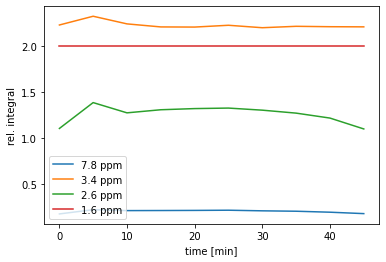

In [87]:
df = pd.DataFrame(#columns=["timestamp"]
)
#df.set_index("timestamp")
for ex in ex_data:
    peak_data={}
    for i,rp in enumerate((ex["peaks"]/PEAK_GROUP_DELTA).astype(int)*PEAK_GROUP_DELTA):
        label="{:.1f} ppm".format(rp)
        peak_data[label]=ex['integrals'][i]
        if label not in df.columns:
            df[label]=np.nan
    df.loc[ex["timestamp"]]=peak_data
    
    #df.append({},ignore_index=True)
df.sort_index(inplace=True)
df["deltaT"]=(df.index-df.index[0]).seconds
df.to_csv("integal_vs_time.csv")

for c in df.columns:
    if c.endswith("ppm"):
        plt.plot(df["deltaT"]/60,df[c],label=c)
plt.legend()
plt.xlabel("time [min]")
plt.ylabel("rel. integral")
plt.show()
plt.close()

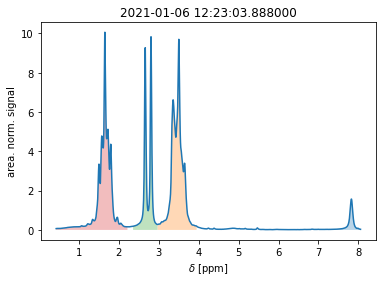

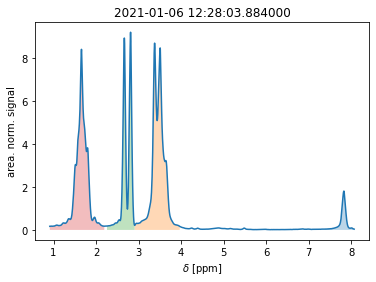

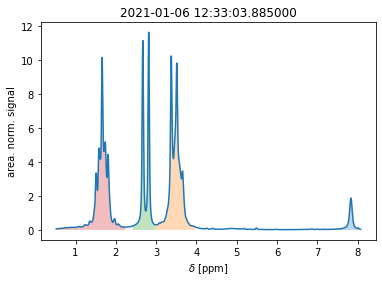

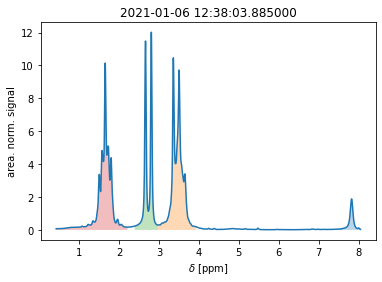

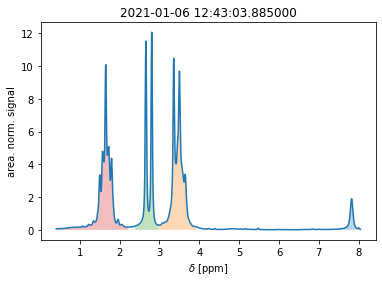

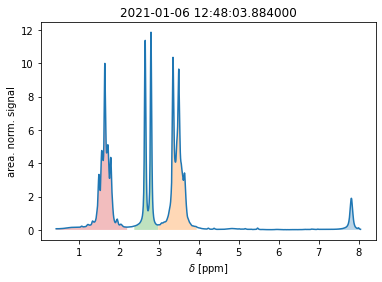

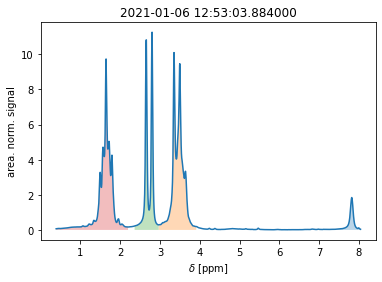

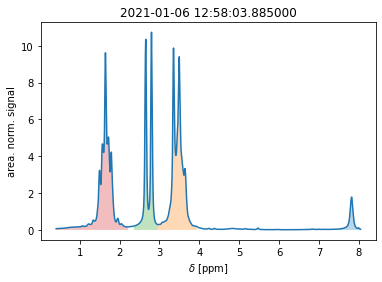

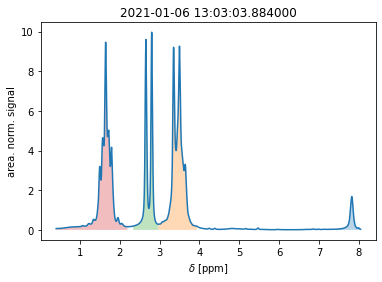

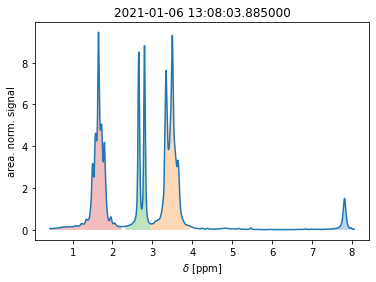

In [90]:
for ex in ex_data:
    mpeak_data=ex["_merged_peaks"][1]
    corr_data = ex["data"]
    merged_peaks=ex["_merged_peaks"][0]
    ppm_scale = ex["ppm_scale"]
    
    plt.plot(ppm_scale[mpeak_data["peak_left_int_bord"].min():mpeak_data["peak_right_int_bord"].max()],
             corr_data[mpeak_data["peak_left_int_bord"].min():mpeak_data["peak_right_int_bord"].max()],)    
    
    #plt.plot(ppm_scale[merged_peaks],mpeak_data["peak_heights"],"o")
    for i,p in enumerate(merged_peaks):
        plt.fill_between(ppm_scale[mpeak_data["peak_left_int_bord"][i]:mpeak_data["peak_right_int_bord"][i]],
                         corr_data[mpeak_data["peak_left_int_bord"][i]:mpeak_data["peak_right_int_bord"][i]],
                         0, alpha=0.30)
    plt.xlabel("$\delta$ [ppm]")
    plt.ylabel("area. norm. signal")
    plt.title(ex["timestamp"])
    plt.show()
    plt.close()